In [1]:
!pip install tensorflow_hub

     |████████████████████████████████| 101 kB 10.2 MB/s ta 0:00:01


In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
import tensorflow as tf
import tensorflow_hub as hub
import tqdm
from tensorflow.keras.models import Sequential

import os


import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
!nvidia-smi

Tue Apr 28 13:21:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Quadro P4000        On   | 00000000:00:05.0 Off |                  N/A |
| 46%   26C    P8     5W / 105W |      1MiB /  8119MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
DATA_DIRECTORY = 'datasets/'

# Load up data

### First up corpus

In [4]:
DL_PREPROCESSED_CORPUS_DUMP = "dl_preprocessed_corpus.p"
corpus = pickle.load(open(os.path.join(DATA_DIRECTORY, DL_PREPROCESSED_CORPUS_DUMP), "rb"))

### Load the tokenized tweets

In [5]:
DL_TOKENIZED_DUMP = "dl_tokenized_tweets.p"
tokenized = pickle.load(open(os.path.join(DATA_DIRECTORY, DL_TOKENIZED_DUMP), "rb"))

### Load up the dataset

In [6]:
DUMP_FILE = "combined_data.p"
data = pickle.load(open(os.path.join(DATA_DIRECTORY, DUMP_FILE), "rb"))

# Data Preparation

In [57]:
data['cleaned'] = corpus

In [58]:
data.head()

,class,tweet,id,cleaned
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,0,as a woman you should not complain about clean...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1,boi dat cold tyga dwn bad for cuffin dat hoe i...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,2,dawg sbabylif you ever fuck a bitch and she st...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,3,she look like a tranni
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,4,the shit you hear about me might be true or it...


### Convert to lists

It was found that keeping things as a series causes strangeness since series index with an index but the lists are ordered indexes

In [59]:
tweets = data.cleaned.values
classes = data['class'].values

In [60]:
tweets[:3]

array(['as a woman you should not complain about clean up your hous as a man you should alwai take the trash out',
       'boi dat cold tyga dwn bad for cuffin dat hoe in the st place',
       'dawg sbabylif you ever fuck a bitch and she sta to cry you be confus as shit'],
      dtype=object)

In [61]:
classes[:3]

array([2, 1, 1])

In [62]:
X_train, X_test, y_train, y_test = train_test_split(tweets, classes, test_size=0.2, 
                                                    stratify=classes, random_state=42)

# Feature Engineering

Most of this flow was adapted from the [Deep TL hack session by DJ Sarkar](https://github.com/dipanjanS/deep_transfer_learning_nlp_dhs2019/blob/master/notebooks/Deep%20TL%20for%20NLP%20-%20Demo.ipynb)

#### Start by creating a vocabulary
This creates a tokenizer and fits it to the training data

In [63]:
t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
t.fit_on_texts(X_train)
t.word_index['<PAD>'] = 0

In [64]:
print(max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), 
      t.word_index['<UNK>'])

('heimer', 33755) ('<PAD>', 0) 1


#### Convert to numbers

We need to convert the text to numbers in the vocabulary index. 

In [65]:
X_train_seq = t.texts_to_sequences(X_train)
X_test_seq = t.texts_to_sequences(X_test)

In [66]:
X_train[0], X_train_seq[0]

('closet muzzi', [2153, 656])

In [67]:
t.sequences_to_texts(X_train_seq)[0]

'closet muzzi'

### Visualize

In [68]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=33756
Number of Documents=35698


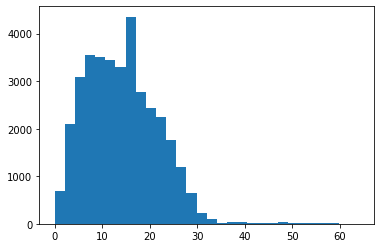

In [69]:
plt.hist([len(doc.split()) for doc in X_train], bins=30);

#### Pad the text with the max of 34

Using 34 since it seems to cover almost every case in the histogram.  This will pad the smaller ones with padding variables so everything is an equal length

In [70]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [71]:
MAX_SEQUENCE_LENGTH = 34

X_train = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

In [72]:
X_train.shape, X_test.shape

((35698, 34), (8925, 34))

## Build Twitter FastText Embedding matrix

In [23]:
FASTTEXT_FILE = './datasets/glove.twitter.27B.200d.txt'
VOCAB_SIZE = len(t.word_index)
EMBED_SIZE = 200

In [43]:
VOCAB_SIZE

33756

In [24]:
word2index = t.word_index

In [25]:
def load_fasttext_embeddings(embedding_file, embedding_size):
    """
    Simply opens up the file and creates a dictionary of word to embeddings.
    This is almost directly taken from the article listed above
    embedding_file: path to fasttest file with vectors
    embedding_size: the number of dimensions of the vectors
    """
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    with open(embedding_file, encoding="utf8", errors='ignore') as f:
        word_vectors = dict(get_coefs(*row.split(' ')) for row in f.readlines())
        
    return word_vectors
            
            

In [26]:
word_embeddings = load_fasttext_embeddings(FASTTEXT_FILE, EMBED_SIZE)

In [27]:
def load_pretrained_embeddings(word_to_index, max_features, word_embeddings):
    """
    Short version of what will be done:
    1. Get the mean and std of the embeddings.
    2. create a matrix with random values from the norm over the entire matrix
    3. run through the list of indexed words and pull any fasttext matches
    
    word_to_index: the dict that connectst he words to the index number that replaces them
    max_features: vocabulary size
    word_embeddings: dict of words mapped to their embeddings
    """
    # Set up information about the embeddings to be able to set defaults
    word_vectors = np.stack(word_embeddings.values())
    embed_mean = word_vectors.mean()
    embed_std = word_vectors.std()
    embed_size = word_vectors.shape[1]
    
    # Generate the randomized matrix within norms
    max_vocab = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(embed_mean, embed_std, (max_vocab, embed_size))
    
    # Loop through the word to index and overlay known embeddings over the random
    for word, idx in word_to_index.items():
        if idx >= max_vocab:
            continue
        embedding_vector = word_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector
            
    return embedding_matrix

In [28]:
feature_embed = load_pretrained_embeddings(word2index, VOCAB_SIZE, word_embeddings)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3331: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [73]:
feature_embed.shape

(33756, 200)

In [74]:
X_train.shape

(35698, 34)

In [75]:
VOCAB_SIZE

33756

## Need to change y for multi class

Since we are doing multiclass classification we need to one hot encode the y_test and y_train

In [32]:
y_train_hot = tf.keras.utils.to_categorical(y_train)
y_test_hot = tf.keras.utils.to_categorical(y_test)

In [33]:
y_train_hot[1000], y_train[1000]

(array([1., 0., 0.], dtype=float32), 0)

# Build Model Architecture

In [123]:
EPOCHS=100
BATCH_SIZE=128

In [124]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Attention, Input

In [186]:
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH, 
#                     batch_input_shape=(BATCH_SIZE, MAX_SEQUENCE_LENGTH),
#                     batch_size=BATCH_SIZE,
                    weights=[feature_embed], trainable=True))
model.add(Bidirectional(LSTM(units=256, return_sequences=True)))
model.add(LSTM(units=256, return_sequences=False))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy', 'accuracy'])
model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_37 (Embedding)     (None, 34, 200)           6751200   
_________________________________________________________________
bidirectional_32 (Bidirectio (None, 34, 512)           935936    
_________________________________________________________________
lstm_58 (LSTM)               (None, 256)               787456    
_________________________________________________________________
dense_91 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_64 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_92 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_65 (Dropout)         (None, 256)             

## Let's see what happens

In [160]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=3,
                                             restore_best_weights=True,
                                             verbose=1)

In [184]:
model.fit(X_train, y_train_hot, validation_data=[X_test, y_test_hot], callbacks=[early_stop],
         epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=1)

Train on 35698 samples, validate on 8925 samples
Epoch 1/100
35698/35698 [==============================] - 22s 611us/sample - loss: 0.4399 - categorical_accuracy: 0.8293 - accuracy: 0.8293 - val_loss: 0.3303 - val_categorical_accuracy: 0.8732 - val_accuracy: 0.8732
Epoch 2/100
35698/35698 [==============================] - 17s 479us/sample - loss: 0.3022 - categorical_accuracy: 0.8832 - accuracy: 0.8832 - val_loss: 0.3079 - val_categorical_accuracy: 0.8836 - val_accuracy: 0.8836
Epoch 3/100
35698/35698 [==============================] - 17s 467us/sample - loss: 0.2266 - categorical_accuracy: 0.9115 - accuracy: 0.9115 - val_loss: 0.3251 - val_categorical_accuracy: 0.8845 - val_accuracy: 0.8845
Epoch 4/100
35698/35698 [==============================] - 17s 465us/sample - loss: 0.1499 - categorical_accuracy: 0.9457 - accuracy: 0.9457 - val_loss: 0.3337 - val_categorical_accuracy: 0.8841 - val_accuracy: 0.8841
Epoch 5/100
35698/35698 [==============================] - 17s 490us/sample - l

In [180]:
results = model.predict(X_test, batch_size=512, verbose=0)

In [175]:
type(results)

numpy.ndarray

In [181]:
y_pred = np.argmax(results, axis=1)

In [182]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.57      0.65      1384
           1       0.94      0.91      0.93      3838
           2       0.87      0.97      0.92      3703

    accuracy                           0.88      8925
   macro avg       0.86      0.82      0.83      8925
weighted avg       0.88      0.88      0.88      8925



# Let's try CNN with it this time

In [204]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

In [326]:
model = Sequential()

model.add(Embedding(VOCAB_SIZE, EMBED_SIZE,
                                    weights=[feature_embed],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))

model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3))

model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3))

model.add(Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.summary()

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_75 (Embedding)     (None, 34, 200)           6751200   
_________________________________________________________________
conv1d_107 (Conv1D)          (None, 34, 256)           256256    
_________________________________________________________________
max_pooling1d_104 (MaxPoolin (None, 11, 256)           0         
_________________________________________________________________
conv1d_108 (Conv1D)          (None, 11, 128)           163968    
_________________________________________________________________
max_pooling1d_105 (MaxPoolin (None, 3, 128)            0         
_________________________________________________________________
conv1d_109 (Conv1D)          (None, 3, 64)             41024     
_________________________________________________________________
max_pooling1d_106 (MaxPoolin (None, 1, 64)           

In [321]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             patience=3,
                                             restore_best_weights=True,
                                             verbose=1)

In [322]:
model.fit(X_train, y_train_hot, validation_data=[X_test, y_test_hot], callbacks=[early_stop],
         epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True, verbose=1)

Train on 35698 samples, validate on 8925 samples
Epoch 1/100
35698/35698 [==============================] - 14s 396us/sample - loss: 0.5272 - categorical_accuracy: 0.7843 - val_loss: 0.3283 - val_categorical_accuracy: 0.8728
Epoch 2/100
35698/35698 [==============================] - 14s 379us/sample - loss: 0.2909 - categorical_accuracy: 0.8896 - val_loss: 0.2964 - val_categorical_accuracy: 0.8878
Epoch 3/100
35698/35698 [==============================] - 14s 383us/sample - loss: 0.1840 - categorical_accuracy: 0.9296 - val_loss: 0.2946 - val_categorical_accuracy: 0.8918
Epoch 4/100
35698/35698 [==============================] - 14s 381us/sample - loss: 0.1064 - categorical_accuracy: 0.9627 - val_loss: 0.3513 - val_categorical_accuracy: 0.8893
Epoch 5/100
35698/35698 [==============================] - 13s 377us/sample - loss: 0.0623 - categorical_accuracy: 0.9791 - val_loss: 0.4397 - val_categorical_accuracy: 0.8877
Epoch 6/100
35698/35698 [==============================] - 14s 390us/sa

In [323]:
results = model.predict(X_test, batch_size=512, verbose=0)

In [324]:
y_pred = np.argmax(results, axis=1)

In [325]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.63      0.69      1384
           1       0.92      0.93      0.93      3838
           2       0.90      0.95      0.92      3703

    accuracy                           0.89      8925
   macro avg       0.86      0.84      0.85      8925
weighted avg       0.89      0.89      0.89      8925

